In [22]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# prevent unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

# Basic imports
import os
import math
import numpy as np
import yfinance as yf
import pandas as pd
import json

import datetime as dt
from numpy import newaxis
# from core.utils import Timer

# Setting up scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier

# Setting up tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

tf.get_logger().setLevel('ERROR')

# Setup plotting
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)


In [43]:
configs = {
    "data": {
        "filename": "use.csv",
        "columns": [
            "Close",
            "Volume",
            "Rule1",
            "Rule2",
            "Rule3",
            "Rule4",
            "Rule5",
            "Rule6",
            "Rule7",
            "Rule8",
            "Rule9"
        ],
        "sequence_length": 50,
        "train_test_split": 0.85,
        "normalise": True
    },
    "training": {
        "epochs": 2,
        "batch_size": 32
    },
    "model": {
        "loss": "mse",
        "optimizer": "adam",
        "save_dir": "saved_models",
        "layers": [
            {
                "type": "lstm",
                "neurons": 100,
                "input_timesteps": 49,
                "input_dim": 7,
                "return_seq": True
            },
            {
                "type": "dropout",
                "rate": 0.2
            },
            {
                "type": "lstm",
                "neurons": 100,
                "return_seq": True
            },
            {
                "type": "lstm",
                "neurons": 100,
                "return_seq": False
            },
            {
                "type": "dropout",
                "rate": 0.2
            },
            {
                "type": "dense",
                "neurons": 1,
                "activation": "linear"
            }
        ]
    }
}

# configs = json.dumps(config)

### Getting the data

In [44]:
# importing data


data = pd.read_csv('data.csv', delimiter="\t")
data.rename(columns = {'<DATE>': 'Date', '<TIME>': 'Time', '<OPEN>': 'open', '<HIGH>': 'high', '<LOW>': 'low', '<CLOSE>': 'close', '<TICKVOL>': 'volume', '<VOL>': 'VOL', '<SPREAD>': 'Spread'}, inplace=True)
# data = train[['Date', 'Open', 'High', 'Low', 'Close',]]

test = pd.read_csv('test.csv', delimiter="\t")
test.rename(columns = {'<DATE>': 'Date', '<TIME>': 'Time', '<OPEN>': 'open', '<HIGH>': 'high', '<LOW>': 'low', '<CLOSE>': 'close', '<TICKVOL>': 'volume', '<VOL>': 'VOL', '<SPREAD>': 'Spread'}, inplace=True)

data

,Date,Time,open,high,low,close,volume,VOL,Spread
0,2023.04.03,00:00:00,1.23247,1.23250,1.23247,1.23250,3,0,100
1,2023.04.03,00:05:00,1.23250,1.23250,1.23245,1.23245,4,0,90
2,2023.04.03,00:10:00,1.23245,1.23252,1.23245,1.23251,19,0,87
3,2023.04.03,00:15:00,1.23252,1.23292,1.23247,1.23247,13,0,19
4,2023.04.03,00:20:00,1.23245,1.23297,1.23242,1.23297,20,0,19
...,...,...,...,...,...,...,...,...,...
5734,2023.04.28,23:30:00,1.25674,1.25688,1.25647,1.25648,123,0,8
5735,2023.04.28,23:35:00,1.25648,1.25674,1.25648,1.25650,149,0,8
5736,2023.04.28,23:40:00,1.25651,1.25655,1.25635,1.25644,61,0,8
5737,2023.04.28,23:45:00,1.25642,1.25665,1.25641,1.25660,103,0,8


### Engineering Features

In [45]:
import pandas as pd
# import talib
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# import ta
# from ta import zigzag, money_flow_index

class FeatureExtractor:
    def __init__(self, df):
        self.df = df
        self.open = df['open'].astype('float')
        self.close = df['close'].astype('float')
        self.high = df['high'].astype('float')
        self.low = df['low'].astype('float')
        self.volume = df['volume'].astype('float')

    def add_bar_features(self):
        # stationary candle
        self.df['bar_hc'] = self.high - self.close
        self.df['bar_ho'] = self.high - self.open
        self.df['bar_hl'] = self.high - self.low
        self.df['bar_cl'] = self.close - self.low
        self.df['bar_ol'] = self.open - self.low
        self.df['bar_co'] = self.close - self.open
        self.df['bar_mov'] = self.df['close'] - self.df['close'].shift(1)

    def add_adj_features(self):
        self.df['adj_open'] = self.df['open'] / self.close
        self.df['adj_high'] = self.df['high'] / self.close
        self.df['adj_low'] = self.df['low'] / self.close
        self.df['adj_close'] = self.df['close'] / self.close
        return self.df

### Processing Data

In [46]:
# Create an instance of FeatureExtractor
train_extractor = FeatureExtractor(data)
# Add bar features
train_extractor.add_bar_features()
# Add adjusted features
train_data = train_extractor.add_adj_features()

# Create an instance of FeatureExtractor
test_extractor = FeatureExtractor(test)
# Add bar features
test_extractor.add_bar_features()
# Add adjusted features
test_data = test_extractor.add_adj_features()

train_data

,Date,Time,open,high,low,close,volume,VOL,Spread,bar_hc,bar_ho,bar_hl,bar_cl,bar_ol,bar_co,bar_mov,adj_open,adj_high,adj_low,adj_close
0,2023.04.03,00:00:00,1.23247,1.23250,1.23247,1.23250,3,0,100,0.00000,0.00003,0.00003,0.00003,0.00000,0.00003,NaN,0.999976,1.000000,0.999976,1.0
1,2023.04.03,00:05:00,1.23250,1.23250,1.23245,1.23245,4,0,90,0.00005,0.00000,0.00005,0.00000,0.00005,-0.00005,-0.00005,1.000041,1.000041,1.000000,1.0
2,2023.04.03,00:10:00,1.23245,1.23252,1.23245,1.23251,19,0,87,0.00001,0.00007,0.00007,0.00006,0.00000,0.00006,0.00006,0.999951,1.000008,0.999951,1.0
3,2023.04.03,00:15:00,1.23252,1.23292,1.23247,1.23247,13,0,19,0.00045,0.00040,0.00045,0.00000,0.00005,-0.00005,-0.00004,1.000041,1.000365,1.000000,1.0
4,2023.04.03,00:20:00,1.23245,1.23297,1.23242,1.23297,20,0,19,0.00000,0.00052,0.00055,0.00055,0.00003,0.00052,0.00050,0.999578,1.000000,0.999554,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,2023.04.28,23:30:00,1.25674,1.25688,1.25647,1.25648,123,0,8,0.00040,0.00014,0.00041,0.00001,0.00027,-0.00026,-0.00026,1.000207,1.000318,0.999992,1.0
5735,2023.04.28,23:35:00,1.25648,1.25674,1.25648,1.25650,149,0,8,0.00024,0.00026,0.00026,0.00002,0.00000,0.00002,0.00002,0.999984,1.000191,0.999984,1.0
5736,2023.04.28,23:40:00,1.25651,1.25655,1.25635,1.25644,61,0,8,0.00011,0.00004,0.00020,0.00009,0.00016,-0.00007,-0.00006,1.000056,1.000088,0.999928,1.0
5737,2023.04.28,23:45:00,1.25642,1.25665,1.25641,1.25660,103,0,8,0.00005,0.00023,0.00024,0.00019,0.00001,0.00018,0.00016,0.999857,1.000040,0.999849,1.0


In [47]:
feature_list = [
    'bar_hc',
    'bar_ho',
    'bar_hl',
    'bar_cl',
    'bar_ol',
    'bar_co', 'close']

target = 'close'

# df.dropna(inplace=True) # drops Nan rows
y_train = train_data['close']
X_train = train_data[feature_list]

X_valid = test_data[feature_list]
y_valid = test_data['close']

X_train.shape

(5739, 7)

### More preprocessing

In [48]:
import datetime as dt

class Timer():

    def __init__(self):
        self.start_dt = None

    def start(self):
        self.start_dt = dt.datetime.now()

    def stop(self):
        end_dt = dt.datetime.now()
        print('Time taken: %s' % (end_dt - self.start_dt))

In [49]:
import math
import numpy as np
import pandas as pd

class DataLoader():
    """A class for loading and transforming data for the lstm model"""

    def __init__(self, data, split, cols):
        dataframe = data
        i_split = int(len(dataframe) * split)
        self.data_train = dataframe.get(cols).values[:i_split]
        self.data_test  = dataframe.get(cols).values[i_split:]
        self.len_train  = len(self.data_train)
        self.len_test   = len(self.data_test)
        self.len_train_windows = None

    def get_test_data(self, seq_len, normalise):
        '''
        Create x, y test data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise reduce size of the training split.
        '''
        data_windows = []
        for i in range(self.len_test - seq_len):
            data_windows.append(self.data_test[i:i+seq_len])

        data_windows = np.array(data_windows).astype(float)
        # data_windows = self.normalise_windows(data_windows, single_window=False) if normalise else data_windows

        x = data_windows[:, :-1]
        y = data_windows[:, -1, [0]]
        return x,y

    def get_train_data(self, seq_len, normalise):
        '''
        Create x, y train data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise use generate_training_window() method.
        '''
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)
        return np.array(data_x), np.array(data_y)

    def generate_train_batch(self, seq_len, batch_size, normalise):
        '''Yield a generator of training data from filename on given list of cols split for train/test'''
        i = 0
        while i < (self.len_train - seq_len):
            x_batch = []
            y_batch = []
            for b in range(batch_size):
                if i >= (self.len_train - seq_len):
                    # stop-condition for a smaller final batch if data doesn't divide evenly
                    yield np.array(x_batch), np.array(y_batch)
                    i = 0
                x, y = self._next_window(i, seq_len, normalise)
                x_batch.append(x)
                y_batch.append(y)
                i += 1
            yield np.array(x_batch), np.array(y_batch)

    def _next_window(self, i, seq_len, normalise):
        '''Generates the next data window from the given index location i'''
        window = self.data_train[i:i+seq_len]
        # window = self.normalise_windows(window, single_window=True)[0] if normalise else window
        x = window[:-1]
        y = window[-1, [0]]
        return x, y

    def normalise_windows(self, window_data, single_window=False):
        '''Normalise window with a base value of zero'''
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        for window in window_data:
            normalised_window = []
            for col_i in range(window.shape[1]):
                normalised_col = [((float(p) / float(window[0, col_i])) - 1) for p in window[:, col_i]]
                normalised_window.append(normalised_col)
            normalised_window = np.array(normalised_window).T # reshape and transpose array back into original multidimensional format
            normalised_data.append(normalised_window)
        return np.array(normalised_data)

In [50]:
split = 0.85
cols = feature_list
sequence_length = 50
batch_size = 32

In [51]:
data = DataLoader(train_data, split, cols)
x, y = data.get_train_data(
        seq_len=sequence_length,
        normalise=True
)


x_test, y_test = data.get_test_data(
        seq_len=sequence_length,
        normalise=True
)

In [52]:
steps_per_epoch = math.ceil((data.len_train - sequence_length / batch_size))
                            

### Modelling

In [53]:
def create_model(shape, nb_actions):
    model = Sequential()
    model.add(LSTM(64, input_shape=shape, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(nb_actions, activation='linear', name="output"))
    return model

In [54]:
class Model():
    """A class for an building and inferencing an lstm model"""

    def __init__(self):
        self.model = Sequential()

    def load_model(self, filepath):
        print('[Model] Loading model from file %s' % filepath)
        self.model = load_model(filepath)

    def build_model(self, configs):
        timer = Timer()
        timer.start()

        for layer in configs['model']['layers']:
            neurons = layer['neurons'] if 'neurons' in layer else None
            dropout_rate = layer['rate'] if 'rate' in layer else None
            activation = layer['activation'] if 'activation' in layer else None
            return_seq = layer['return_seq'] if 'return_seq' in layer else None
            input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
            input_dim = layer['input_dim'] if 'input_dim' in layer else None

            if layer['type'] == 'dense':
                self.model.add(Dense(neurons, activation=activation))
            if layer['type'] == 'lstm':
                self.model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
            if layer['type'] == 'dropout':
                self.model.add(Dropout(dropout_rate))

        self.model.compile(loss=configs['model']['loss'], optimizer=configs['model']['optimizer'])

        print('[Model] Model Compiled')
        timer.stop()

    def train(self, x, y, epochs, batch_size, save_dir):
        timer = Timer()
        timer.start()
        print('[Model] Training Started')
        print('[Model] %s epochs, %s batch size' % (epochs, batch_size))

        save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=2),
            ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
        ]
        self.model.fit(
            x,
            y,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks
        )
        self.model.save(save_fname)

        print('[Model] Training Completed. Model saved as %s' % save_fname)
        timer.stop()

    def train_generator(self, data_gen, epochs, batch_size, steps_per_epoch, save_dir):
        timer = Timer()
        timer.start()
        print('[Model] Training Started')
        print('[Model] %s epochs, %s batch size, %s batches per epoch' % (epochs, batch_size, steps_per_epoch))

        save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
        callbacks = [
            ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)
        ]
        self.model.fit_generator(
            data_gen,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            callbacks=callbacks,
            workers=1
        )

        print('[Model] Training Completed. Model saved as %s' % save_fname)
        timer.stop()

    def predict_point_by_point(self, data):
        #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
        print('[Model] Predicting Point-by-Point...')
        predicted = self.model.predict(data)
        predicted = np.reshape(predicted, (predicted.size,))
        return predicted

    def predict_sequences_multiple(self, data, window_size, prediction_len):
        #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
        print('[Model] Predicting Sequences Multiple...')
        prediction_seqs = []
        for i in range(int(len(data)/prediction_len)):
            curr_frame = data[i*prediction_len]
            predicted = []
            for j in range(prediction_len):
                predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
                curr_frame = curr_frame[1:]
                curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
            prediction_seqs.append(predicted)
        return prediction_seqs

    def predict_sequence_full(self, data, window_size):
        #Shift the window by 1 new prediction each time, re-run predictions on new window
        print('[Model] Predicting Sequences Full...')
        curr_frame = data[0]
        predicted = []
        for i in range(len(data)):
            predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
        return predicted


In [55]:
model = Model()
model.build_model(configs)

[Model] Model Compiled
Time taken: 0:00:00.576029


In [56]:
model.train_generator(
        data_gen=data.generate_train_batch(
            seq_len=configs['data']['sequence_length'],
            batch_size=configs['training']['batch_size'],
            normalise=configs['data']['normalise']
        ),
        epochs=configs['training']['epochs'],
        batch_size=configs['training']['batch_size'],
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir']
)

[Model] Training Started
[Model] 2 epochs, 32 batch size, 4877 batches per epoch
Epoch 1/2
4877/4877 [==============================] - 83s 16ms/step - loss: 8.5672e-05
[Model] Training Completed. Model saved as saved_models/13072023-091954-e2.h5
Time taken: 0:01:22.579765


In [57]:
predictions = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])

[Model] Predicting Sequences Multiple...
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


In [59]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    # Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

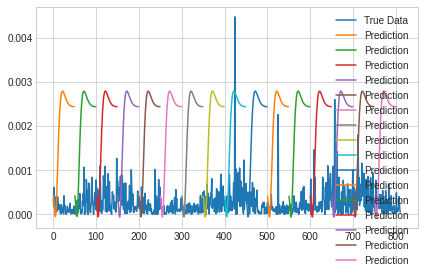

In [60]:
plot_results_multiple(predictions, y_test, configs['data']['sequence_length'])

In [ ]:
import process_data
import pandas as pd
import random
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import math
from pathlib import Path

# position constant
LONG = 0
SHORT = 1
FLAT = 2

# action constant
BUY = 0
SELL = 1
HOLD = 2

class OhlcvEnv(gym.Env):

    def __init__(self, window_size, path, show_trade=True):
        self.show_trade = show_trade
        self.path = path
        self.actions = ["LONG", "SHORT", "FLAT"]
        self.fee = 0.0005
        self.seed()
        self.file_list = []
        # load_csv
        self.load_from_csv()

        # n_features
        self.window_size = window_size
        self.n_features = self.df.shape[1]
        self.shape = (self.window_size, self.n_features+4)

        # defines action space
        self.action_space = spaces.Discrete(len(self.actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float32)

    def load_from_csv(self):
        if(len(self.file_list) == 0):
            self.file_list = [x.name for x in Path(self.path).iterdir() if x.is_file()]
            self.file_list.sort()
        self.rand_episode = self.file_list.pop()
        raw_df= pd.read_csv(self.path + self.rand_episode)
        extractor = process_data.FeatureExtractor(raw_df)
        self.df = extractor.add_bar_features() # bar features o, h, l, c ---> C(4,2) = 4*3/2*1 = 6 features

        ## selected manual fetuares
        feature_list = [
            'bar_hc',
            'bar_ho',
            'bar_hl',
            'bar_cl',
            'bar_ol',
            'bar_co', 'close']
        self.df.dropna(inplace=True) # drops Nan rows
        self.closingPrices = self.df['close'].values
        self.df = self.df[feature_list].values

    def render(self, mode='human', verbose=False):
        return None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):

        if self.done:
            return self.state, self.reward, self.done, {}
        self.reward = 0

        # action comes from the agent
        # 0 buy, 1 sell, 2 hold
        # single position can be opened per trade
        # valid action sequence would be
        # LONG : buy - hold - hold - sell
        # SHORT : sell - hold - hold - buy
        # invalid action sequence is just considered hold
        # (e.g.) "buy - buy" would be considred "buy - hold"
        self.action = HOLD  # hold
        if action == BUY: # buy
            if self.position == FLAT: # if previous position was flat
                self.position = LONG # update position to long
                self.action = BUY # record action as buy
                self.entry_price = self.closingPrice # maintain entry price
            elif self.position == SHORT: # if previous position was short
                self.position = FLAT  # update position to flat
                self.action = BUY # record action as buy
                self.exit_price = self.closingPrice
                self.reward += ((self.entry_price - self.exit_price)/self.exit_price + 1)*(1-self.fee)**2 - 1 # calculate reward
                self.krw_balance = self.krw_balance * (1.0 + self.reward) # evaluate cumulative return in krw-won
                self.entry_price = 0 # clear entry price
                self.n_short += 1 # record number of short
        elif action == 1: # vice versa for short trade
            if self.position == FLAT:
                self.position = SHORT
                self.action = 1
                self.entry_price = self.closingPrice
            elif self.position == LONG:
                self.position = FLAT
                self.action = 1
                self.exit_price = self.closingPrice
                self.reward += ((self.exit_price - self.entry_price)/self.entry_price + 1)*(1-self.fee)**2 - 1
                self.krw_balance = self.krw_balance * (1.0 + self.reward)
                self.entry_price = 0
                self.n_long += 1

        # [coin + krw_won] total value evaluated in krw won
        if(self.position == LONG):
            temp_reward = ((self.closingPrice - self.entry_price)/self.entry_price + 1)*(1-self.fee)**2 - 1
            new_portfolio = self.krw_balance * (1.0 + temp_reward)
        elif(self.position == SHORT):
            temp_reward = ((self.entry_price - self.closingPrice)/self.closingPrice + 1)*(1-self.fee)**2 - 1
            new_portfolio = self.krw_balance * (1.0 + temp_reward)
        else:
            temp_reward = 0
            new_portfolio = self.krw_balance

        self.portfolio = new_portfolio
        self.current_tick += 1
        if(self.show_trade and self.current_tick%100 == 0):
            print("Tick: {0}/ Portfolio (krw-won): {1}".format(self.current_tick, self.portfolio))
            print("Long: {0}/ Short: {1}".format(self.n_long, self.n_short))
        self.history.append((self.action, self.current_tick, self.closingPrice, self.portfolio, self.reward))
        self.updateState()
        if (self.current_tick > (self.df.shape[0]) - self.window_size-1):
            self.done = True
            self.reward = self.get_profit() # return reward at end of the game
        return self.state, self.reward, self.done, {'portfolio':np.array([self.portfolio]),
                                                    "history":self.history,
                                                    "n_trades":{'long':self.n_long, 'short':self.n_short}}

    def get_profit(self):
        if(self.position == LONG):
            profit = ((self.closingPrice - self.entry_price)/self.entry_price + 1)*(1-self.fee)**2 - 1
        elif(self.position == SHORT):
            profit = ((self.entry_price - self.closingPrice)/self.closingPrice + 1)*(1-self.fee)**2 - 1
        else:
            profit = 0
        return profit

    def reset(self):
        # self.current_tick = random.randint(0, self.df.shape[0]-1000)
        self.current_tick = 0
        print("start episode ... {0} at {1}" .format(self.rand_episode, self.current_tick))

        # positions
        self.n_long = 0
        self.n_short = 0

        # clear internal variables
        self.history = [] # keep buy, sell, hold action history
        self.krw_balance = 100 * 10000 # initial balance, u can change it to whatever u like
        self.portfolio = float(self.krw_balance) # (coin * current_price + current_krw_balance) == portfolio
        self.profit = 0

        self.action = HOLD
        self.position = FLAT
        self.done = False

        self.updateState() # returns observed_features +  opened position(LONG/SHORT/FLAT) + profit_earned(during opened position)
        return self.state


    def updateState(self):
        def one_hot_encode(x, n_classes):
            return np.eye(n_classes)[x]
        self.closingPrice = float(self.closingPrices[self.current_tick])
        prev_position = self.position
        one_hot_position = one_hot_encode(prev_position,3)
        profit = self.get_profit()
        # append two
        self.state = np.concatenate((self.df[self.current_tick], one_hot_position, [profit]))
        return self.state


In [33]:
shape = (X_train.shape[1], 1)
nb_actions = 1

model = create_model(shape, nb_actions)

In [34]:
model.compile(
    optimizer='adam',
    loss='mae',
)

#### Fitting the model

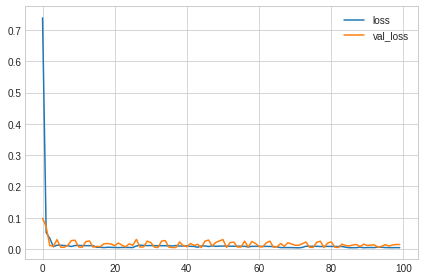

In [35]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=100,
    verbose=0,
)


# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();


In [36]:
predictions = model.predict(X_valid)

81/81 [==============================] - 1s 4ms/step


#### Plotting predictions vs actual data

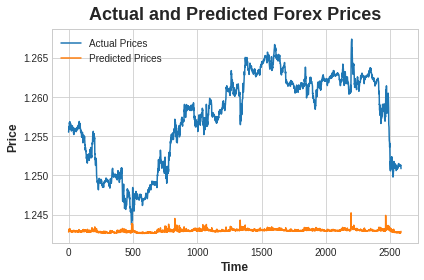

In [37]:
import matplotlib.pyplot as plt

def plot_forex_prices(actual_prices, predicted_prices):
    fig, ax = plt.subplots()

    ax.plot(actual_prices, label='Actual Prices')
    ax.plot(predicted_prices, label='Predicted Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Actual and Predicted Forex Prices')
    plt.legend()
    plt.show()

plot_forex_prices(y_valid, predictions)

In [43]:
y_valid
predictions

array([[1.2427849],
       [1.2428311],
       [1.2429429],
       ...,
       [1.2426792],
       [1.2427144],
       [1.2428629]], dtype=float32)

In [61]:
def calculate_mape(actual, predicted):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).
    
    Args:
        actual (list or numpy array): Actual values.
        predicted (list or numpy array): Predicted values.
        
    Returns:
        float: The MAPE value.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    errors = np.abs((actual - predicted) / actual)
    mape = np.mean(errors) * 100
    
    return mape


In [62]:
calculate_mape(y_test, predictions)

ValueError: operands could not be broadcast together with shapes (811,1) (16,50) 

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, verbose=0, callbacks=[early_stopping])

In [ ]:
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_returns = returns - risk_free_rate
    mean_excess_returns = np.mean(excess_returns)
    std_excess_returns = np.std(excess_returns)
    sharpe_ratio = mean_excess_returns / std_excess_returns
    return sharpe_ratio

In [ ]:
def calculate_alpha(returns, market_returns, risk_free_rate):
    excess_returns = returns - risk_free_rate
    beta, alpha = np.polyfit(market_returns, excess_returns, 1)
    return alpha


In [ ]:
def calculate_drawdown(returns):
    cumulative_returns = np.cumprod(1 + returns)
    previous_peaks = np.maximum.accumulate(cumulative_returns)
    drawdowns = (cumulative_returns - previous_peaks) / previous_peaks
    max_drawdown = np.min(drawdowns)
    return max_drawdown


In [ ]:
# Example usage

returns = np.array([0.05, 0.02, -0.03, 0.04, 0.01])
risk_free_rate = 0.02

market_returns = np.array([0.03, 0.02, 0.01, 0.05, 0.04])

sharpe_ratio = calculate_sharpe_ratio(returns, risk_free_rate)
alpha = calculate_alpha(returns, market_returns, risk_free_rate)
profit = calculate_profit(returns)
drawdown = calculate_drawdown(returns)

print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Alpha: {alpha}")
print(f"Profit: {profit}")
print(f"Max Drawdown: {drawdown}")